In [1]:
from helpers import laplace, divergence, gradient, ImageFitting
from siren import Siren

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

In [2]:
cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)

/home/lc3267/Documents/CodeWorkspace/quantum-siren/.venv/lib64/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Step 0, Total loss 0.327586


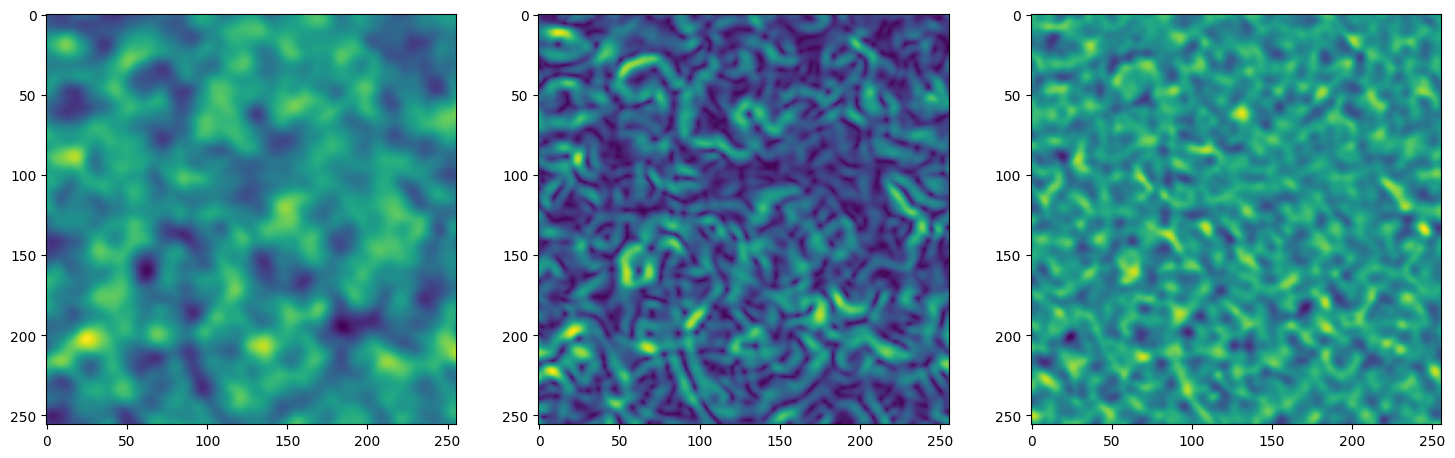

Step 10, Total loss 0.050562


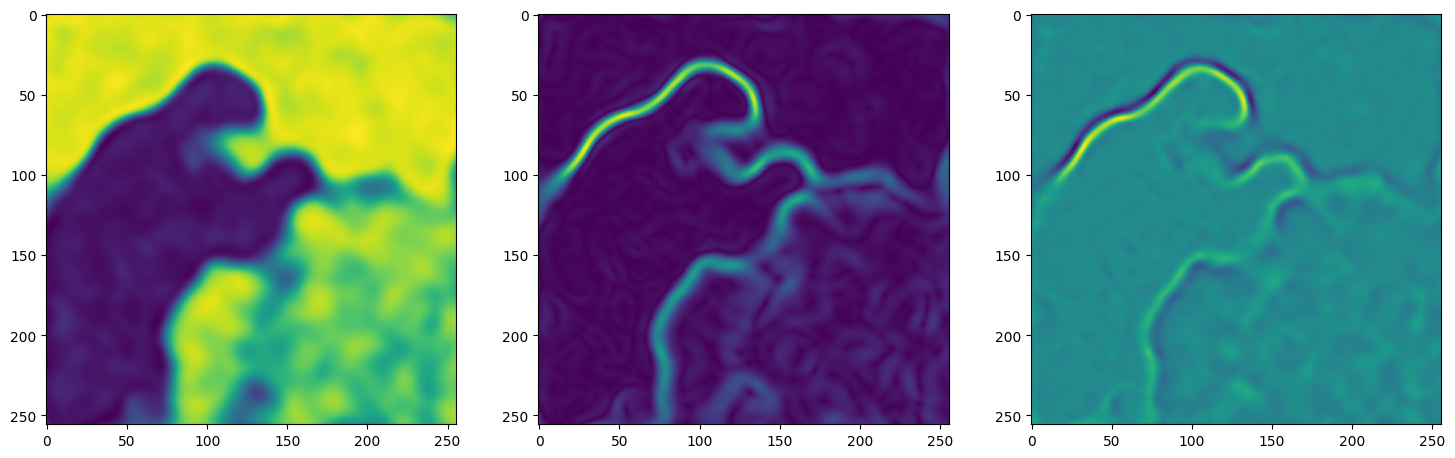

KeyboardInterrupt: 

In [4]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input, ground_truth

for step in range(total_steps):
    model_output, coords = img_siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(256,256).detach().numpy())
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(256,256).detach().numpy())
        axes[2].imshow(img_laplacian.cpu().view(256,256).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()